# Business Problem:

## Background

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.

Source: https://www.hopkinsmedicine.org/health/conditions-and-diseases/pneumonia

## Problem Statement

We need to be able to quickly and accurately identify which patients have pneumonia using a model, so that doctors themselves spend less time reviewing images.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
from PIL import Image

# Data Exploration

## Data Load

In [2]:
# Define function for reading images and labeling
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_data('Data/chest_xray/train')
test = get_data('Data/chest_xray/test')
val = get_data('Data/chest_xray/val')

OpenCV(4.5.2) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-k95y01np/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.2) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-k95y01np/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-2-4bed3dfa1382>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


OpenCV(4.5.2) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-k95y01np/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.2) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-k95y01np/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



## Data Fields

/Users/paulvithayathil/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

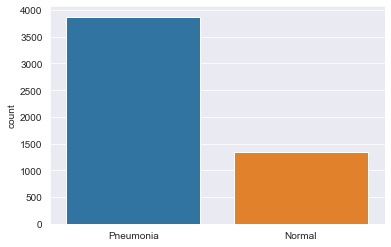

In [4]:
#Countplot of image classification groups
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l) 

- Data is imbalanced

Text(0.5, 1.0, 'NORMAL')

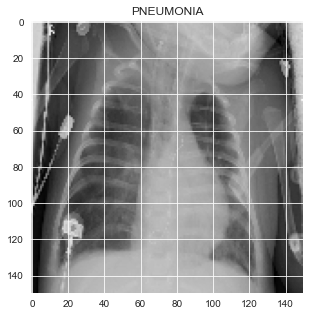

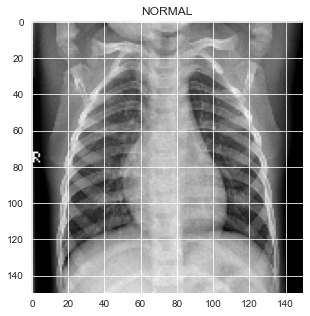

In [5]:
# Print examples of each image classification group
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [6]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Data Preparation

## Normalize

Each RGB pixel in an image takes a value between 0 and 255. In Deep Learning, it is very common to standardize and/or center your dataset. For images, a common thing that is done is to make sure each pixel value is between 0 and 1. This can be done by dividing the entire matrix by 255. 

In [7]:
# Normalize the data - grayscale normalization to reduce illumination differences
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

## Resize

In [8]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## Data Augmentation

To avoid overfitting we should artificially expand our data. We will alter the training data with small transformations to reproduce variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. 

Augmentations: grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and more. We will apply a couple of these transformations to our training data, to increase the number of training examples.

In [9]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)


- Randomly rotate some training images by 30 degrees
- Randomly Zoom by 20% some training images
- Randomly shift images horizontally by 10% of the width
- Randomly shift images vertically by 10% of the height
- Randomly flip images horizontally. Once our model is ready, we fit the training dataset.

In [10]:
datagen_test = ImageDataGenerator()
datagen_test.fit(x_val)

# Model Development

### Conclusion: Adding layers does not improve the model, Best model was first one with less layers

In [51]:
#Reduce learning rate when a metric has stopped improving.
learning_rate_reduction = ReduceLROnPlateau(monitor='auc',
                                            factor=0.3, ## change
                                            #min_delta=0.0001, ### added
                                            patience=2, 
                                            verbose=1, 
                                            min_lr=0.000001)
# monitor: quantity to be monitored.
# factor: factor by which the learning rate will be reduced. new_lr = lr * factor.
# patience: number of epochs with no improvement after which learning rate will be reduced.
# verbose: int. 0: quiet, 1: update messages.
# min_lr: lower bound on the learning rate.

2D convolution layer (e.g. spatial convolution over images).

This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well.

When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers or None, does not include the sample axis), e.g. input_shape=(128, 128, 3) for 128x128 RGB pictures in data_format="channels_last". You can use None when a dimension has variable size.

Padding - amount of pixels added to an image when it is being processed by the kernel of a CNN. For example, if the padding in a CNN is set to zero, then every pixel value that is added will be of value zero.

SAME Padding: it applies padding to the input image so that the input image gets fully covered by the filter and specified stride.It is called SAME because, for stride 1 , the output will be the same as the input.

Stride is a parameter of the neural network's filter that modifies the amount of movement over the image or video. For example, if a neural network's stride is set to 1, the filter will move one pixel, or unit, at a time.

In artificial neural networks, the activation function of a node defines the output of that node given an input or set of inputs. 

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

Dropout is a technique used to prevent a model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase.

In [52]:
#Build a Sequential Model - Baseline
model = Sequential()
model.add(Conv2D(32 , (3,3) , 
                 input_shape = (img_size,img_size,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy','AUC'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 175232)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               22429824  
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

In [53]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32),
                    epochs = 10, 
                    validation_data = datagen_test.flow(x_val, y_val),
                    callbacks = [learning_rate_reduction],
                   )

Epoch 1/10
163/163 [==============================] - 69s 408ms/step - loss: 62.5480 - accuracy: 0.7328 - auc: 0.6652 - val_loss: 15.2775 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/10
163/163 [==============================] - 63s 386ms/step - loss: 3.1221 - accuracy: 0.8221 - auc: 0.8108 - val_loss: 5.7827 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 3/10
163/163 [==============================] - 64s 392ms/step - loss: 0.5066 - accuracy: 0.8351 - auc: 0.8742 - val_loss: 1.7636 - val_accuracy: 0.5000 - val_auc: 0.8281

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
163/163 [==============================] - 62s 381ms/step - loss: 0.2641 - accuracy: 0.8883 - auc: 0.9439 - val_loss: 1.0399 - val_accuracy: 0.6250 - val_auc: 0.8359
Epoch 5/10
163/163 [==============================] - 62s 379ms/step - loss: 0.2385 - accuracy: 0.8991 - auc: 0.9530 - val_loss: 1.5916 - val_accuracy: 0.6250 - val_auc: 0.8281

Epoch 00005: ReduceLROnPlateau 

In [54]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("AUC of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 3s 97ms/step - loss: 0.5030 - accuracy: 0.7981 - auc: 0.9554
Loss of the model is -  0.5029860138893127
20/20 [==============================] - 2s 103ms/step - loss: 0.5030 - accuracy: 0.7981 - auc: 0.9554
AUC of the model is -  79.80769276618958 %


In [55]:
#Build a Sequential Model - Iteration_1
model_1 = Sequential()
model_1.add(Conv2D(32 , (3,3) , strides = 1 , 
                 padding = 'same' , activation = 'relu' , 
                 input_shape = (img_size,img_size,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_1.add(Flatten())
model_1.add(Dense(units = 128 , activation = 'relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(units = 1 , activation = 'sigmoid'))
model_1.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['AUC'])
model_1.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_15 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 180000)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               23040128  
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

In [56]:
history = model_1.fit(datagen.flow(x_train,y_train, batch_size = 32),
                    epochs = 2, 
                    validation_data = datagen_test.flow(x_val, y_val),
                    callbacks = [learning_rate_reduction])

Epoch 1/2
163/163 [==============================] - 98s 571ms/step - loss: 7.0402 - auc: 0.7287 - val_loss: 0.7058 - val_auc: 0.5781
Epoch 2/2
163/163 [==============================] - 65s 398ms/step - loss: 0.4045 - auc: 0.8918 - val_loss: 0.6098 - val_auc: 0.7969


In [57]:
print("Loss of the model is - " , model_1.evaluate(x_test,y_test)[0])
print("AUC of the model is - " , model_1.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 71ms/step - loss: 0.4503 - auc: 0.9126
Loss of the model is -  0.4503205120563507
20/20 [==============================] - 2s 80ms/step - loss: 0.4503 - auc: 0.9126
AUC of the model is -  91.2584900856018 %


## Adding Layers

In [58]:
#Build a Sequential Model - Iteration_2
model_2 = Sequential()
model_2.add(Conv2D(32 , (3,3) , strides = 1 , 
                 padding = 'same' , activation = 'relu' , 
                 input_shape = (img_size,img_size,1)))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_2.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_2.add(Dropout(0.1))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_2.add(Flatten())
model_2.add(Dense(units = 128 , activation = 'relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(units = 1 , activation = 'sigmoid'))
model_2.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['AUC'])
model_2.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_16 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_15 (Dropout)         (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 38, 38, 64)      

In [59]:
history = model_2.fit(datagen.flow(x_train,y_train, batch_size = 32),
                    epochs = 2, 
                    validation_data = datagen_test.flow(x_val, y_val),
                    callbacks = [learning_rate_reduction])

Epoch 1/2
163/163 [==============================] - 100s 594ms/step - loss: 5.1214 - auc: 0.7058 - val_loss: 36.3354 - val_auc: 0.5000
Epoch 2/2
163/163 [==============================] - 95s 583ms/step - loss: 0.3868 - auc: 0.9035 - val_loss: 38.4127 - val_auc: 0.5000


In [60]:
print("Loss of the model is - " , model_2.evaluate(x_test,y_test)[0])
print("AUC of the model is - " , model_2.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 5s 241ms/step - loss: 28.7327 - auc: 0.5000
Loss of the model is -  28.732675552368164
20/20 [==============================] - 4s 198ms/step - loss: 28.7327 - auc: 0.5000
AUC of the model is -  50.0 %


loss function is used to measure the inconsistency between the predicted value  (𝑦̂ )  and the actual label  𝑦 .

## Changing Strides

### Conclusion: Increasing strides improves the model up to 4 strides

In [24]:
#Build a Sequential Model - Iteration_3
model_4 = Sequential()
model_4.add(Conv2D(32 , (3,3) , strides =2 , 
                 padding = 'same' , activation = 'relu' , 
                 input_shape = (img_size,img_size,1)))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_4.add(Flatten())
model_4.add(Dense(units = 128 , activation = 'relu'))
model_4.add(Dropout(0.2))
model_4.add(Dense(units = 1 , activation = 'sigmoid'))
model_4.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['AUC'])
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 75, 75, 32)        320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 38, 38, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 46208)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               5914752   
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [25]:
history = model_4.fit(datagen.flow(x_train,y_train, batch_size = 32),
                    epochs = 2, 
                    validation_data = datagen_test.flow(x_val, y_val),
                    callbacks = [learning_rate_reduction])

Epoch 1/2
163/163 [==============================] - 17s 99ms/step - loss: 0.8528 - auc: 0.8170 - val_loss: 0.7739 - val_auc: 0.8281
Epoch 2/2
163/163 [==============================] - 15s 91ms/step - loss: 0.2559 - auc: 0.9493 - val_loss: 0.6344 - val_auc: 0.8203


In [26]:
print("Loss of the model is - " , model_4.evaluate(x_test,y_test)[0])
print("AUC of the model is - " , model_4.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 16ms/step - loss: 0.4318 - auc: 0.9341
Loss of the model is -  0.4318377673625946
20/20 [==============================] - 0s 16ms/step - loss: 0.4318 - auc: 0.9341
AUC of the model is -  93.41003894805908 %


In [27]:
#Build a Sequential Model - Iteration_5
model_5 = Sequential()
model_5.add(Conv2D(32 , (3,3) , strides = 4 , 
                 padding = 'same' , activation = 'relu' , 
                 input_shape = (img_size,img_size,1)))
model_5.add(BatchNormalization())
model_5.add(MaxPool2D((2,2) , strides = 4 , padding = 'same'))
model_5.add(Flatten())
model_5.add(Dense(units = 128 , activation = 'relu'))
model_5.add(Dropout(0.2))
model_5.add(Dense(units = 1 , activation = 'sigmoid'))
model_5.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['AUC'])
model_5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 38, 38, 32)        320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 38, 38, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               409728    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [28]:
history = model_5.fit(datagen.flow(x_train,y_train, batch_size = 32),
                    epochs = 5, 
                    validation_data = datagen_test.flow(x_val, y_val),
                    callbacks = [learning_rate_reduction])

Epoch 1/5
163/163 [==============================] - 13s 74ms/step - loss: 0.5645 - auc: 0.7442 - val_loss: 0.7058 - val_auc: 0.6953
Epoch 2/5
163/163 [==============================] - 10s 59ms/step - loss: 0.2846 - auc: 0.9349 - val_loss: 0.8997 - val_auc: 0.7578
Epoch 3/5
163/163 [==============================] - 9s 58ms/step - loss: 0.2386 - auc: 0.9525 - val_loss: 0.6863 - val_auc: 0.8203

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/5
163/163 [==============================] - 10s 59ms/step - loss: 0.2060 - auc: 0.9653 - val_loss: 1.0380 - val_auc: 0.8359
Epoch 5/5
163/163 [==============================] - 10s 63ms/step - loss: 0.2070 - auc: 0.9638 - val_loss: 0.6902 - val_auc: 0.8906

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.


In [29]:
print("Loss of the model is - " , model_5.evaluate(x_test,y_test)[0])
print("AUC of the model is - " , model_5.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 5ms/step - loss: 0.3410 - auc: 0.9443
Loss of the model is -  0.3410068452358246
20/20 [==============================] - 0s 5ms/step - loss: 0.3410 - auc: 0.9443
AUC of the model is -  94.43074464797974 %


## Change padding

### Conclusion: Changing padding to valid improves model

In [71]:
#Build a Sequential Model - Iteration_4
model_6 = Sequential()
model_6.add(Conv2D(32 , (3,3) , strides = 4 , 
                 padding = 'valid' , activation = 'relu' , 
                 input_shape = (img_size,img_size,1)))
model_6.add(BatchNormalization())
model_6.add(MaxPool2D((2,2) , strides = 4 , padding = 'same'))
model_6.add(Flatten())
model_6.add(Dense(units = 128 , activation = 'relu'))
model_6.add(Dropout(0.2))
model_6.add(Dense(units = 1 , activation = 'sigmoid'))
model_6.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['AUC'])
model_6.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 37, 37, 32)        320       
_________________________________________________________________
batch_normalization_21 (Batc (None, 37, 37, 32)        128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 3200)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               409728    
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)               

In [73]:
history = model_6.fit(datagen.flow(x_train,y_train, batch_size = 32),
                    epochs = 30, 
                    #steps_per_epoch = x_train.shape[0]/128,
                    validation_data = datagen_test.flow(x_val, y_val),
                    #validation_steps=1,
                    callbacks = [learning_rate_reduction])

Epoch 1/30
163/163 [==============================] - 11s 69ms/step - loss: 0.2694 - auc: 0.9413 - val_loss: 0.9519 - val_auc: 0.8203
Epoch 2/30
163/163 [==============================] - 9s 57ms/step - loss: 0.2333 - auc: 0.9548 - val_loss: 0.7912 - val_auc: 0.8438
Epoch 3/30
163/163 [==============================] - 9s 57ms/step - loss: 0.2261 - auc: 0.9582 - val_loss: 0.4259 - val_auc: 0.8750

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/30
163/163 [==============================] - 9s 57ms/step - loss: 0.1924 - auc: 0.9694 - val_loss: 0.5435 - val_auc: 0.8125
Epoch 5/30
163/163 [==============================] - 9s 57ms/step - loss: 0.1877 - auc: 0.9701 - val_loss: 0.6488 - val_auc: 0.8672

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/30
163/163 [==============================] - 9s 58ms/step - loss: 0.1765 - auc: 0.9743 - val_loss: 1.2422 - val_auc: 0.8281
Epoch 7/30
163/163 [===================

In [74]:
print("Loss of the model is - " , model_6.evaluate(x_test,y_test)[0])
print("AUC of the model is - " , model_6.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 6ms/step - loss: 0.3660 - auc: 0.9336
Loss of the model is -  0.36598387360572815
20/20 [==============================] - 0s 6ms/step - loss: 0.3660 - auc: 0.9336
AUC of the model is -  93.35910081863403 %


## Add back a convolution layer
We may have not have performed enough epochs when testing layers let's add another layer and perform a larger number of epochs to be sure

In [100]:
#Build a Sequential Model - Iteration_5
model_7 = Sequential()
model_7.add(Conv2D(32 , (3,3) , strides = 1 , 
                 padding = 'valid' , activation = 'relu' , 
                 input_shape = (img_size,img_size,1)))
model_7.add(BatchNormalization())
model_7.add(MaxPool2D((2,2) , strides = 4 , padding = 'valid'))
model_7.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'))
model_7.add(Dropout(0.1))
model_7.add(BatchNormalization())
model_7.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
model_7.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
model_7.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'))
model_7.add(Dropout(0.2))
model_7.add(BatchNormalization())
model_7.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
model_7.add(Flatten())
model_7.add(Dense(units = 128 , activation = 'relu'))
model_7.add(Dropout(0.2))
model_7.add(Dense(units = 1 , activation = 'sigmoid'))
model_7.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['AUC'])
model_7.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
batch_normalization_38 (Batc (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 35, 35, 64)        18496     
_________________________________________________________________
dropout_31 (Dropout)         (None, 35, 35, 64)        0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 35, 35, 64)        256       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 17, 17, 64)      

In [101]:
history = model_7.fit(datagen.flow(x_train,y_train, batch_size = 32),
                    epochs = 10, 
                    validation_data = datagen_test.flow(x_val, y_val),
                    callbacks = [learning_rate_reduction])

Epoch 1/10
163/163 [==============================] - 52s 303ms/step - loss: 0.4740 - auc: 0.8749 - val_loss: 4.6862 - val_auc: 0.5000
Epoch 2/10
163/163 [==============================] - 46s 281ms/step - loss: 0.2733 - auc: 0.9437 - val_loss: 8.4231 - val_auc: 0.5000
Epoch 3/10
163/163 [==============================] - 47s 285ms/step - loss: 0.2148 - auc: 0.9628 - val_loss: 11.7272 - val_auc: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
163/163 [==============================] - 48s 292ms/step - loss: 0.1766 - auc: 0.9742 - val_loss: 1.9361 - val_auc: 0.8750
Epoch 5/10
163/163 [==============================] - 48s 291ms/step - loss: 0.1589 - auc: 0.9788 - val_loss: 5.3378 - val_auc: 0.6250

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/10
163/163 [==============================] - 47s 290ms/step - loss: 0.1635 - auc: 0.9748 - val_loss: 0.4992 - val_auc: 0.8438
Epoch 7/10
163/163 [=======

In [107]:
print("Loss of the model is - " , model_7.evaluate(x_test,y_test)[0])
print("AUC of the model is - " , model_7.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 3s 109ms/step - loss: 0.2690 - auc: 0.9545
Loss of the model is -  0.26896294951438904
20/20 [==============================] - 2s 103ms/step - loss: 0.2690 - auc: 0.9545
AUC of the model is -  95.45474648475647 %


In [82]:
#Build a Sequential Model - Iteration_6
model_3 = Sequential()
model_3.add(Conv2D(32 , (3,3) , strides = 1 , 
                 padding = 'same' , activation = 'relu' , 
                 input_shape = (img_size,img_size,1)))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_3.add(Dropout(0.1))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_3.add(Dropout(0.2))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(Flatten())
model_3.add(Dense(units = 128 , activation = 'relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(units = 1 , activation = 'sigmoid'))
model_3.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['AUC'])
model_3.summary()


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_22 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_20 (Dropout)         (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 38, 38, 64)      

In [83]:
history = model_3.fit(datagen.flow(x_train,y_train, batch_size = 32),
                    epochs = 30, 
                    validation_data = datagen_test.flow(x_val, y_val),
                    callbacks = [learning_rate_reduction])

Epoch 1/30
163/163 [==============================] - 135s 816ms/step - loss: 0.9840 - auc: 0.8248 - val_loss: 37.2968 - val_auc: 0.5000
Epoch 2/30
163/163 [==============================] - 98s 603ms/step - loss: 0.2825 - auc: 0.9401 - val_loss: 29.2954 - val_auc: 0.5000
Epoch 3/30
163/163 [==============================] - 96s 591ms/step - loss: 0.2722 - auc: 0.9471 - val_loss: 9.5567 - val_auc: 0.5781

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/30
163/163 [==============================] - 96s 590ms/step - loss: 0.1970 - auc: 0.9731 - val_loss: 0.4922 - val_auc: 0.7969
Epoch 5/30
163/163 [==============================] - 95s 581ms/step - loss: 0.1568 - auc: 0.9790 - val_loss: 24.6777 - val_auc: 0.6250

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/30
163/163 [==============================] - 96s 588ms/step - loss: 0.1181 - auc: 0.9867 - val_loss: 0.5185 - val_auc: 0.8203
Epoch 7/30
163/163 [====

In [84]:
print("Loss of the model is - " , model_3.evaluate(x_test,y_test)[0])
print("AUC of the model is - " , model_3.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 5s 184ms/step - loss: 0.2942 - auc: 0.9519
Loss of the model is -  0.2941884398460388
20/20 [==============================] - 4s 190ms/step - loss: 0.2942 - auc: 0.9519
AUC of the model is -  95.19065618515015 %


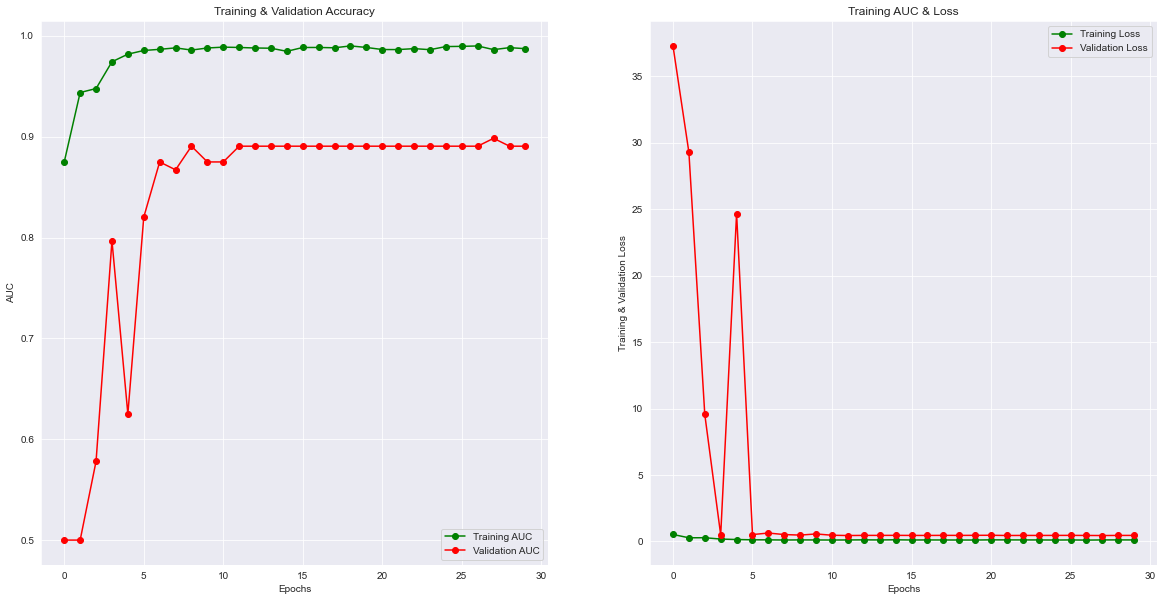

In [85]:
epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['auc']
train_loss = history.history['loss']
val_acc = history.history['val_auc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training AUC')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation AUC')
ax[0].set_title('Training & Validation AUC')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("AUC")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training AUC & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [92]:
predictions = model_3.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

/Users/paulvithayathil/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [93]:

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.91      0.93      0.92       390
   Normal (Class 1)       0.88      0.85      0.87       234

           accuracy                           0.90       624
          macro avg       0.90      0.89      0.90       624
       weighted avg       0.90      0.90      0.90       624



In [94]:
cm = confusion_matrix(y_test,predictions)
cm

array([[364,  26],
       [ 34, 200]])

In [95]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

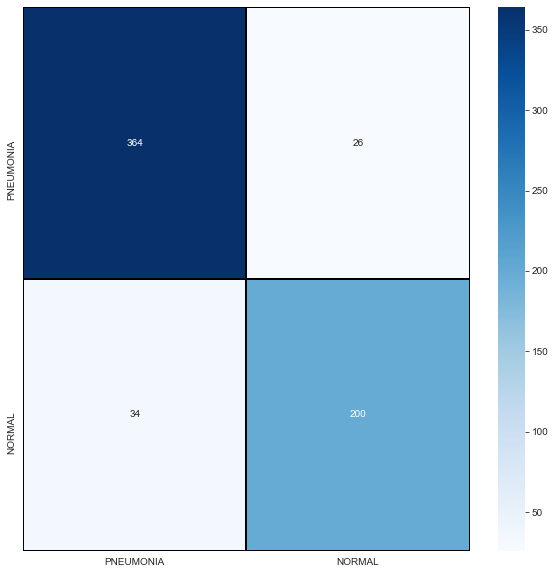

In [96]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [102]:
predictions_train = model_3.predict_classes(x_train)
predictions_train = predictions_train.reshape(1,-1)[0]
predictions_train[:15]

/Users/paulvithayathil/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [104]:
cm_train = confusion_matrix(y_train,predictions_train)
cm_train

array([[3435,  440],
       [  14, 1327]])

In [105]:
cm_train = pd.DataFrame(cm_train , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

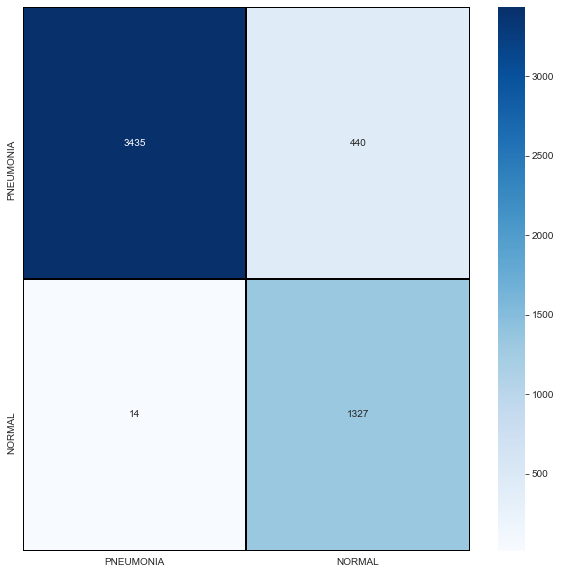

In [106]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_train,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

When comparing our confusion matricies our model does not appear to be overfitting

In [ ]:
#Metric not lining up with the business problem, 
#more focused interpretation of model, and better tracking of performance of thee model

In [89]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

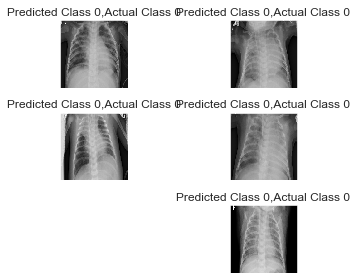

In [90]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

Above are examples of the correctly predicted classes

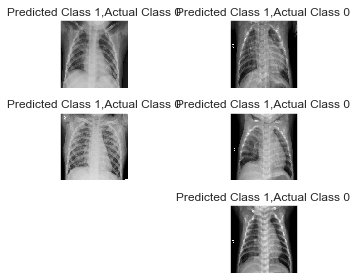

In [91]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1


Above are examples of the incorrectly predicted Classes

# Conclusions

Our model performed decently but not at the level necessary for medical accuracy

Pneumonia images which had less cloudiness or lung infiltrates were difficult for the model to classify

7% of pneumonia patients were misclassified as normal which is good enough to corroborate  more obvious  images but not good  enough to classify patients with more mild pneumonia  

# Recommendations

Utilize the model for corroboration of physician assessment of x-ray images

Wait until future work is completed to use a model as a primary classification technique

Explore the use of other performance metrics in the model - Does another metric perform better than AUC?

Expand validation set with some of the training set - the validation set provided was far too small

Iterate the model with more layers - initially additional layers didn't seem important when run with limited epochs but when running with a larger number of epochs there were improvements in AUC metric


# Future Work

Incorporate transfer learning 
 if a model is trained on a large and general enough dataset, this model will effectively serve as a model of the visual world.
 
Iterate the model with more layers
 
Expand validation set with some of the training set - the validation set provided was far too small

